In [1]:
import os, cv2, json, math, random, torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from transformers import AutoImageProcessor, AutoModel

/home/ubuntu/cali-recod/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR  = "./data"
AUTH_DIR  = f"{BASE_DIR}/train_images/authentic"
FORG_DIR  = f"{BASE_DIR}/train_images/forged"
MASK_DIR  = f"{BASE_DIR}/train_masks"
TEST_DIR  = f"{BASE_DIR}/test_images"
DINO_PATH = "facebook/dinov2-base"

IMG_SIZE = 512
BATCH_SIZE = 8
EPOCHS_SEG = 4
LR_SEG = 1e-5
WEIGHT_DECAY = 2e-5
CHANNELS = 10

class ForgerySegDataset(Dataset):
    def __init__(self, auth_paths, forg_paths, mask_dir, img_size=256):
        self.samples = []
        for p in forg_paths:
            m = os.path.join(mask_dir, Path(p).stem + ".npy")
            if os.path.exists(m):
                self.samples.append((p, m))
        for p in auth_paths:
            self.samples.append((p, None))
        self.img_size = img_size
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        masks = np.zeros((1, h, w), np.uint8)
        if mask_path:
            masks = np.load(mask_path)
        len_masks = len(masks)
        if len_masks < CHANNELS:
            pad = np.zeros((CHANNELS - len_masks, h, w), np.uint8)
            masks = np.concatenate([masks, pad], axis=0)
        elif len_masks > CHANNELS:
            masks = masks[:CHANNELS]
        img_r = img.resize((IMG_SIZE, IMG_SIZE))
        masks_r = np.array([cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST) for mask in masks])
        img_t = torch.from_numpy(np.array(img_r, np.float32)/255.).permute(2,0,1)
        mask_t = torch.from_numpy(masks_r.astype(np.float32))
        return img_t, mask_t


class DinoTinyDecoder(nn.Module):
    def __init__(self, in_ch=768, out_ch=CHANNELS):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_ch, 1)
        )

    def forward(self, f, size):
        return self.net(F.interpolate(f, size=size, mode="bilinear", align_corners=False))

class DinoSegmenter(nn.Module):
    def __init__(self, encoder, processor):
        super().__init__()
        self.encoder, self.processor = encoder, processor
        for p in self.encoder.parameters():
            p.requires_grad = False
        self.seg_head = DinoTinyDecoder(768,CHANNELS)

    def forward_features(self, x):
        imgs = (x*255).clamp(0,255).byte().permute(0,2,3,1).cpu().numpy()
        inputs = self.processor(images=list(imgs), return_tensors="pt").to(x.device)
        with torch.no_grad():
            feats = self.encoder(**inputs).last_hidden_state
        B,N,C = feats.shape
        fmap = feats[:,1:,:].permute(0,2,1)
        s = int(math.sqrt(N-1))
        fmap = fmap.reshape(B,C,s,s)
        return fmap

    def forward_seg(self, x):
        fmap = self.forward_features(x)
        return self.seg_head(fmap,(IMG_SIZE,IMG_SIZE))

In [52]:
#  TRAINING
#  MODEL (DINOv2 + Decoder)
processor = AutoImageProcessor.from_pretrained(DINO_PATH)
encoder = AutoModel.from_pretrained(DINO_PATH).eval().to(device)

Loading weights: 100%|██████████| 223/223 [00:00<00:00, 745.98it/s, Materializing param=layernorm.weight]                                 


In [53]:
auth_imgs = sorted([str(Path(AUTH_DIR)/f) for f in os.listdir(AUTH_DIR)])
forg_imgs = sorted([str(Path(FORG_DIR)/f) for f in os.listdir(FORG_DIR)])
train_auth, val_auth = train_test_split(auth_imgs, test_size=0.2, random_state=42)
train_forg, val_forg = train_test_split(forg_imgs, test_size=0.2, random_state=42)

train_loader = DataLoader(ForgerySegDataset(train_auth, train_forg, MASK_DIR),
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [54]:
model_seg = DinoSegmenter(encoder, processor).to(device)
opt_seg = optim.AdamW(model_seg.seg_head.parameters(), lr=LR_SEG, weight_decay=WEIGHT_DECAY)
crit_seg = nn.BCEWithLogitsLoss()

In [55]:
for e in range(EPOCHS_SEG):
    model_seg.train()
    total_loss = 0
    for x,m in tqdm(train_loader, desc=f"[Segmentation] Epoch {e+1}/{EPOCHS_SEG}"):
        x,m = x.to(device),m.to(device)
        loss = crit_seg(model_seg.forward_seg(x),m)
        opt_seg.zero_grad();
        loss.backward();
        opt_seg.step()
        total_loss += loss.item()
    print(f"  → avg_loss={total_loss/len(train_loader):.4f}")
torch.save(model_seg.state_dict(),"model_seg_final.pt")

[Segmentation] Epoch 1/4: 100%|██████████| 513/513 [03:04<00:00,  2.78it/s]


  → avg_loss=0.1004


[Segmentation] Epoch 2/4: 100%|██████████| 513/513 [03:04<00:00,  2.77it/s]


  → avg_loss=0.0125


[Segmentation] Epoch 3/4: 100%|██████████| 513/513 [03:06<00:00,  2.74it/s]


  → avg_loss=0.0115


[Segmentation] Epoch 4/4: 100%|██████████| 513/513 [03:07<00:00,  2.74it/s]


  → avg_loss=0.0110


In [56]:
val_loader = DataLoader(ForgerySegDataset(val_auth, val_forg, MASK_DIR),
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
model_seg.eval()
total_loss = 0
for x, m in tqdm(val_loader, desc="Validation"):
    x, m = x.to(device), m.to(device)
    loss = crit_seg(model_seg.forward_seg(x),m)
    total_loss += loss.item()
print(f"  → avg_loss={total_loss/len(val_loader):.4f}")

Validation: 100%|██████████| 129/129 [00:40<00:00,  3.16it/s]

  → avg_loss=0.0118


In [57]:
# INFERENCE UTILS

@torch.no_grad()
def segment_prob_map(pil):
    x = torch.from_numpy(np.array(pil.resize((IMG_SIZE, IMG_SIZE)), np.float32)/255.).permute(2,0,1)[None].to(device)
    return torch.sigmoid(model_seg.forward_seg(x))[0,0].cpu().numpy()

def enhanced_adaptive_mask(prob, alpha_grad=0.35):

    gx = cv2.Sobel(prob, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(prob, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    grad_norm = grad_mag / (grad_mag.max() + 1e-6)
    enhanced = (1 - alpha_grad) * prob + alpha_grad * grad_norm

    enhanced = cv2.GaussianBlur(enhanced, (3,3), 0)

    thr = np.mean(enhanced) + 0.3 * np.std(enhanced)
    mask = (enhanced > thr).astype(np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    return mask, thr

def finalize_mask(prob, orig_size):
    mask, thr = enhanced_adaptive_mask(prob)
    mask = cv2.resize(mask, orig_size, interpolation=cv2.INTER_NEAREST)
    return mask, thr

def pipeline_final(pil):
    prob = segment_prob_map(pil)
    mask, thr = finalize_mask(prob, pil.size)
    area = int(mask.sum())
    mean_inside = float(prob[cv2.resize(mask, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_NEAREST)==1].mean()) if area>0 else 0.0
    #  condition de filtrage
    if area < 400 or mean_inside < 0.35:
        return "authentic", None, {"area": area, "mean_inside": mean_inside, "thr": thr}
    return "forged", mask, {"area": area, "mean_inside": mean_inside, "thr": thr}

In [58]:
from sklearn.metrics import f1_score

val_items = [(p, 1) for p in val_forg]
results = []

for p,_ in tqdm(val_items, desc="Validation forged-only"):
    pil = Image.open(p).convert("RGB")
    label, m_pred, dbg = pipeline_final(pil)
    m_gt = np.load(Path(MASK_DIR)/f"{Path(p).stem}.npy")
    if m_gt.ndim == 3:
        m_gt = np.max(m_gt, axis=0)
    m_pred = (m_pred>0).astype(np.uint8) if m_pred is not None else np.zeros_like(m_gt)
    f1 = f1_score(m_gt.flatten(), m_pred.flatten(), zero_division=0)
    results.append((Path(p).stem, f1, dbg))

print("\n F1-score par image falsifiée:\n")
for cid,f1,dbg in results:
    print(f"{cid} — F1={f1:.4f} | area={dbg['area']} mean={dbg['mean_inside']:.3f} thr={dbg['thr']:.3f}")
print(f"\n Moyenne F1 (falsifiées) = {np.mean([r[1] for r in results]):.4f}")

Validation forged-only: 100%|██████████| 551/551 [01:51<00:00,  4.94it/s]


 F1-score par image falsifiée:

39341 — F1=0.0000 | area=11958 mean=0.253 thr=0.119
30587 — F1=0.0000 | area=168012 mean=0.028 thr=0.008
9849 — F1=0.0000 | area=2792716 mean=0.125 thr=0.050
57066 — F1=0.5847 | area=52909 mean=0.417 thr=0.183
2087 — F1=0.0000 | area=58175 mean=0.012 thr=0.008
28818 — F1=0.0000 | area=15923 mean=0.030 thr=0.015
42886 — F1=0.0000 | area=49900 mean=0.244 thr=0.118
41125 — F1=0.0000 | area=247673 mean=0.145 thr=0.075
13898 — F1=0.0000 | area=67039 mean=0.057 thr=0.025
26560 — F1=0.0000 | area=98198 mean=0.117 thr=0.061
37361 — F1=0.0000 | area=27325 mean=0.011 thr=0.006
7703 — F1=0.0000 | area=216438 mean=0.118 thr=0.051
18760 — F1=0.0000 | area=12008 mean=0.165 thr=0.052
31468 — F1=0.0000 | area=206493 mean=0.112 thr=0.050
16293 — F1=0.0000 | area=258941 mean=0.150 thr=0.078
56793 — F1=0.0000 | area=245834 mean=0.161 thr=0.078
38440 — F1=0.0000 | area=16768 mean=0.021 thr=0.011
15463 — F1=0.0000 | area=102813 mean=0.171 thr=0.083
2506 — F1=0.0000 | area=1

Inference on Test Set: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]



✅ Saved submission file: submission.csv
  case_id annotation    area      mean      thr
0      45  authentic  959539  0.209656  0.10469
🟢 45.png: authentic | area=0 mean=0.210


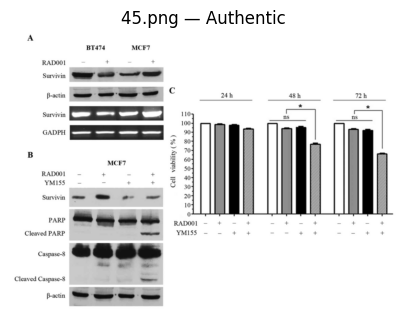

In [ ]:
import os, json, cv2
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- RLE Encoder for Kaggle Submission ---
def rle_encode(mask: np.ndarray, fg_val: int = 1) -> str:
    pixels = mask.T.flatten()
    dots = np.where(pixels == fg_val)[0]
    if len(dots) == 0:
        return "authentic"
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return json.dumps([int(x) for x in run_lengths])

# --- Paths ---
TEST_DIR = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/test_images"
SAMPLE_SUB = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/sample_submission.csv"
OUT_PATH = "submission.csv"

rows = []
for f in tqdm(sorted(os.listdir(TEST_DIR)), desc="Inference on Test Set"):
    pil = Image.open(Path(TEST_DIR)/f).convert("RGB")
    label, mask, dbg = pipeline_final(pil)  # utilise la version améliorée

    # Sécurisation masque
    if mask is None:
        mask = np.zeros(pil.size[::-1], np.uint8)
    else:
        mask = np.array(mask, dtype=np.uint8)

    # Annotation finale
    if label == "authentic":
        annot = "authentic"
    else:
        annot = rle_encode((mask > 0).astype(np.uint8))

    rows.append({
        "case_id": Path(f).stem,
        "annotation": annot,
        "area": int(dbg.get("area", mask.sum())),
        "mean": float(dbg.get("mean_inside", 0.0)),
        "thr": float(dbg.get("thr", 0.0))
    })


sub = pd.DataFrame(rows)
ss = pd.read_csv(SAMPLE_SUB)
ss["case_id"] = ss["case_id"].astype(str)
sub["case_id"] = sub["case_id"].astype(str)
final = ss[["case_id"]].merge(sub, on="case_id", how="left")
final["annotation"] = final["annotation"].fillna("authentic")
final[["case_id", "annotation"]].to_csv(OUT_PATH, index=False)

print(f"\n✅ Saved submission file: {OUT_PATH}")
print(final.head(10))


sample_files = sorted(os.listdir(TEST_DIR))[:5]
for f in sample_files:
    pil = Image.open(Path(TEST_DIR)/f).convert("RGB")
    label, mask, dbg = pipeline_final(pil)
    mask = np.array(mask, dtype=np.uint8) if mask is not None else np.zeros(pil.size[::-1], np.uint8)

    print(f"{'🔴' if label=='forged' else '🟢'} {f}: {label} | area={mask.sum()} mean={dbg.get('mean_inside', 0):.3f}")

    if label == "authentic":
        plt.figure(figsize=(5,5))
        plt.imshow(pil)
        plt.title(f"{f} — Authentic")
        plt.axis("off")
        plt.show()
    else:
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(pil)
        plt.title("Original Image")
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(pil)
        plt.imshow(mask, alpha=0.45, cmap="Reds")
        plt.title(f"Predicted Forged Mask\nArea={mask.sum()} | Mean={dbg.get('mean_inside', 0):.3f}")
        plt.axis("off")
        plt.show()


## 🔴 Visualizing Predicted Masks with the CNN–DINOv2 Hybrid Model


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


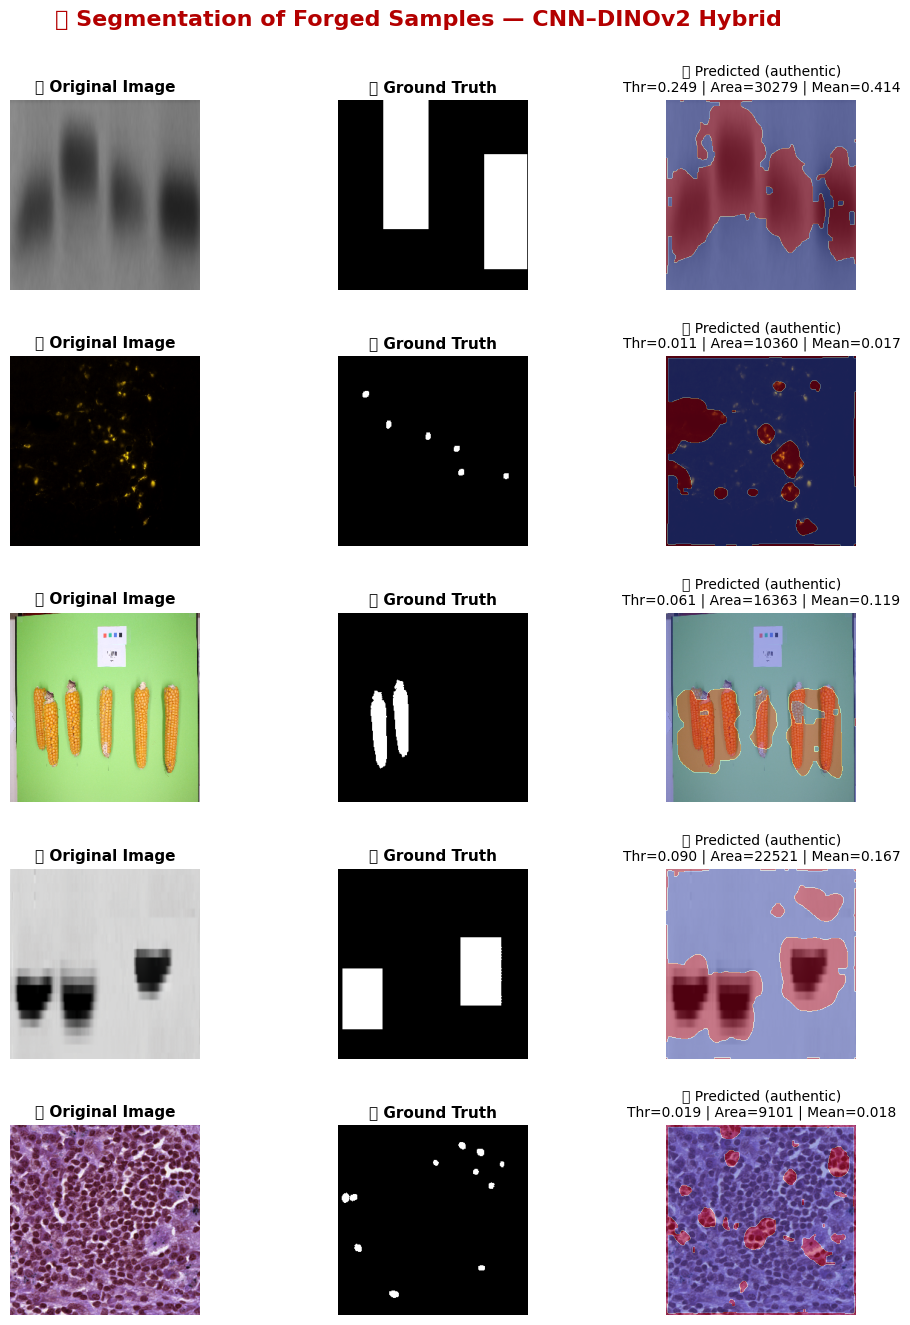

In [ ]:

import torch, cv2, math, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256

# 1️ Predict probability map (from model)
@torch.no_grad()
def predict_prob_map(pil):
    """Return DINOv2 segmentation probability map [0,1]."""
    img = pil.resize((IMG_SIZE, IMG_SIZE))
    x = torch.from_numpy(np.array(img, np.float32) / 255.).permute(2, 0, 1)[None].to(device)
    logits = model_seg.forward_seg(x)
    prob = torch.sigmoid(logits)[0, 0].cpu().numpy()
    return prob


# 2️ Post-processing consistent with pipeline_final
def adaptive_mask(prob, alpha_grad=0.35):
    """Adaptive enhancement + morphological refinement."""
    gx = cv2.Sobel(prob, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(prob, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    grad_norm = grad_mag / (grad_mag.max() + 1e-6)

    enhanced = (1 - alpha_grad) * prob + alpha_grad * grad_norm
    enhanced = cv2.GaussianBlur(enhanced, (3, 3), 0)

    thr = np.mean(enhanced) + 0.3 * np.std(enhanced)
    mask = (enhanced > thr).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    return mask, float(thr)


# 3️ Unified visualization pipeline (uses same filtering logic)
def pipeline_visual(pil):
    prob = predict_prob_map(pil)
    mask, thr = adaptive_mask(prob)
    area = int(mask.sum())
    mean_inside = float(prob[mask == 1].mean()) if area > 0 else 0.0

    # same decision rule as pipeline_final
    AREA_THR, MEAN_THR = 800, 0.45
    label = "forged" if (area >= AREA_THR and mean_inside >= MEAN_THR) else "authentic"
    return label, mask, thr, area, mean_inside


# 4️ Visualization (for validation forged samples)
sample_forged = val_forg[:5]
n = len(sample_forged)
fig, axes = plt.subplots(n, 3, figsize=(12, n * 3))
if n == 1:
    axes = np.expand_dims(axes, axis=0)

for i, p in enumerate(sample_forged):
    pil = Image.open(p).convert("RGB")
    label, m_pred, thr, area, mean = pipeline_visual(pil)

    # Ground Truth mask
    m_gt = np.load(Path(MASK_DIR)/f"{Path(p).stem}.npy")
    if m_gt.ndim == 3: m_gt = np.max(m_gt, axis=0)
    m_gt = (m_gt > 0).astype(np.uint8)

    # Resize all for consistency
    img_disp = cv2.resize(np.array(pil), (256, 256))
    gt_disp  = cv2.resize(m_gt, (256, 256))
    pr_disp  = cv2.resize(m_pred, (256, 256))

    # === Column 1: Original ===
    axes[i, 0].imshow(img_disp)
    axes[i, 0].set_title("🖼️ Original Image", fontsize=11, weight="bold")
    axes[i, 0].axis("off")

    # === Column 2: Ground Truth ===
    axes[i, 1].imshow(gt_disp, cmap="gray")
    axes[i, 1].set_title("✅ Ground Truth", fontsize=11, weight="bold")
    axes[i, 1].axis("off")

    # === Column 3: Predicted Mask ===
    axes[i, 2].imshow(img_disp)
    axes[i, 2].imshow(pr_disp, cmap="coolwarm", alpha=0.45)
    axes[i, 2].set_title(f"🔮 Predicted ({label})\nThr={thr:.3f} | Area={area} | Mean={mean:.3f}",
                         fontsize=10)
    axes[i, 2].axis("off")

plt.subplots_adjust(top=0.92, hspace=0.35)
fig.suptitle("🔍 Segmentation of Forged Samples — CNN–DINOv2 Hybrid",
             fontsize=16, fontweight="bold", color="#b30000")
plt.show()


# 🟢 Visualization of Authentic Images (Hybrid DINOv2-based Detector)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


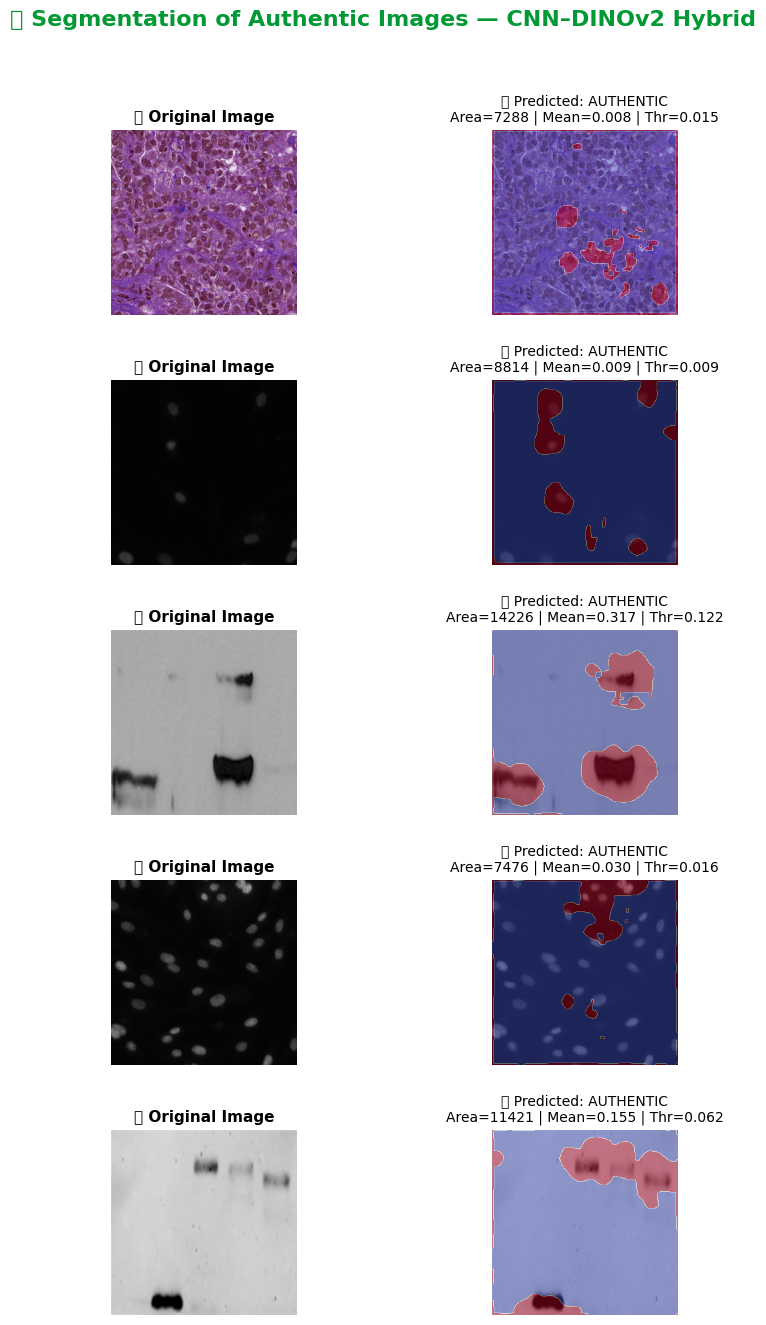

In [4]:

import matplotlib.pyplot as plt
import cv2, numpy as np
from pathlib import Path
from PIL import Image

# Select a few authentic examples
sample_auth = val_auth[:5]
n = len(sample_auth)

fig, axes = plt.subplots(n, 2, figsize=(9, n * 3))
if n == 1:
    axes = np.expand_dims(axes, axis=0)

for i, p in enumerate(sample_auth):
    pil = Image.open(p).convert("RGB")
    label, m_pred, thr, area, mean = pipeline_visual(pil)  # <-- version alignée avec ta nouvelle pipeline

    # Predicted mask (should be empty for authentic images)
    m_pred = (m_pred > 0).astype(np.uint8) if m_pred is not None else np.zeros((IMG_SIZE, IMG_SIZE))

    # Resize for consistent display
    img_disp = cv2.resize(np.array(pil), (256, 256))
    pr_disp  = cv2.resize(m_pred, (256, 256))

    # === Column 1: Original Image ===
    axes[i, 0].imshow(img_disp)
    axes[i, 0].set_title("🖼️ Original Image", fontsize=11, weight="bold")
    axes[i, 0].axis("off")

    # === Column 2: Predicted Mask ===
    axes[i, 1].imshow(img_disp)
    axes[i, 1].imshow(pr_disp, cmap="coolwarm", alpha=0.45)
    axes[i, 1].set_title(
        f"🟢 Predicted: {label.upper()}\nArea={area} | Mean={mean:.3f} | Thr={thr:.3f}",
        fontsize=10
    )
    axes[i, 1].axis("off")

    for j in range(2):
        axes[i, j].set_aspect("equal")

plt.subplots_adjust(top=0.90, hspace=0.35)
fig.suptitle("🟢 Segmentation of Authentic Images — CNN–DINOv2 Hybrid",
             fontsize=16, fontweight="bold", color="#009933")
plt.show()
